In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
from brian2 import *
from brian2tools import *
from utils.equations import *
from utils.eq_params import *
from utils.funcs import plot_ln_G_vs_voltages, ln_G, comp_Zeff


prefs.codegen.target = "numpy"

In [3]:
def max_conductances(voltages, neuron_group, neuron_group_statemon, restore_name):
    """
    Returns a list of max conductance values for given neuron group and list of voltages

    :param voltages: list of voltages to iterate over
    :param neuron_group: NeuronGroup to set voltage for each iteration
    :param neuron_group_statemon: StateMonitor to record current values
    :return: list of max conductance values
    """
    max_g = []
    for v in voltages:
        restore(restore_name)
        neuron_group.v = v
        run(200 * ms)
        max_g.append(abs(neuron_group_statemon.INa18[0]).max() / v)
    return max_g


def plot_currents(voltages, m_model_neuron, m_model_statemon, restore_name):
    """
    Plots current values for given list of voltages
    
    :param voltages: list of voltages to iterate over
    :param m_model_neuron: NeuronGroup to set voltage for each iteration 
    :param m_model_statemon: StateMonitor to record current values
    """
    for v in voltages:
        restore(restore_name)
        m_model_neuron.v = v
        run(100 * ms)
        plot(m_model_statemon.t / ms, m_model_statemon.INa18[0] / nA)
    xlabel("Time (ms)")
    ylabel("Current (nA)")
    grid()


Equation check

## Construct $Z_{eff}$ to evaluate Nav1.8 equaions above

### Nav1.8 literature equations

WARNING    'v' is an internal variable of group 'Nav18', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'Nav18', but also exists in the run namespace with the value -40. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'Nav18', but also exists in the run namespace with the value -30. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'Nav18', but also exists in the run namespace with the value -20. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


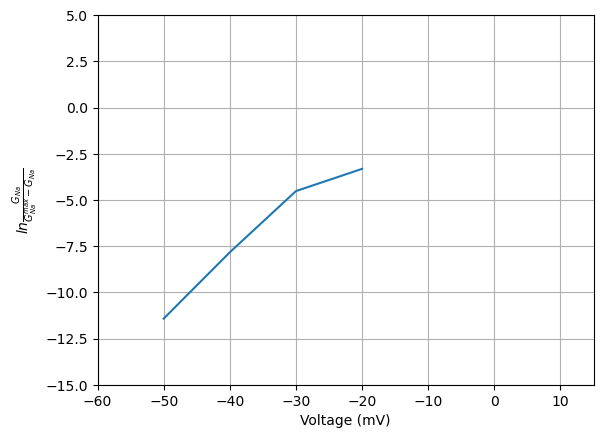

In [4]:
start_scope()
g18nav = 200*nS
patchclamp_gna18_eq = gNa18_eq + Equations("v : volt (constant)")

nav18_only_group = NeuronGroup(1, patchclamp_gna18_eq,
                               namespace={"gNa18": g18nav}, method="exponential_euler",
                               name="Nav18")
nav18_only_statemon = StateMonitor(nav18_only_group, ["INa18"], True)

store("patch_clamp_init")

experimental_voltages = arange(-50, -10, 10) * mV
nav18_max_gs = max_conductances(experimental_voltages, nav18_only_group, nav18_only_statemon, "patch_clamp_init")
plot_ln_G_vs_voltages(nav18_max_gs, experimental_voltages, g18nav)

## Krylov equations

### $m^3$ model

WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -40. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -30. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -20. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


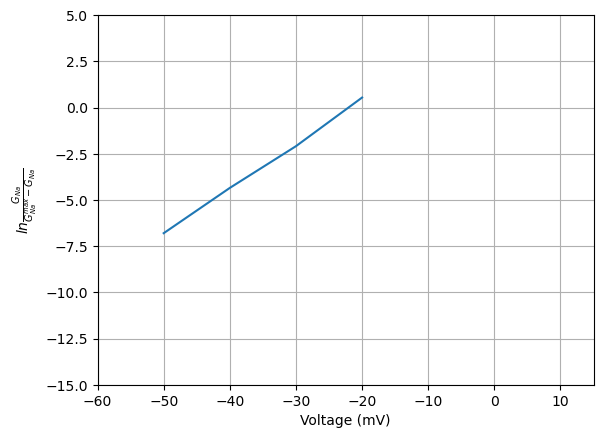

In [5]:
start_scope()
g18nav = 200 * nS
patchclamp_m3_model_eq = m3_model + Equations("v : volt (constant)")
m3_model_neuron = NeuronGroup(1, model=patchclamp_m3_model_eq, method="exponential_euler", namespace={"gNa18": g18nav})
m3_model_statemon = StateMonitor(m3_model_neuron, ["INa18"], record=True)
store("patch_clamp_m3_model")

m3_max_gs = max_conductances(experimental_voltages, m3_model_neuron, m3_model_statemon, "patch_clamp_m3_model")
plot_ln_G_vs_voltages(m3_max_gs, experimental_voltages, g18nav)

### $m3 h_s$ model

#### a - slow kinetics

WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -40. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -30. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -20. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


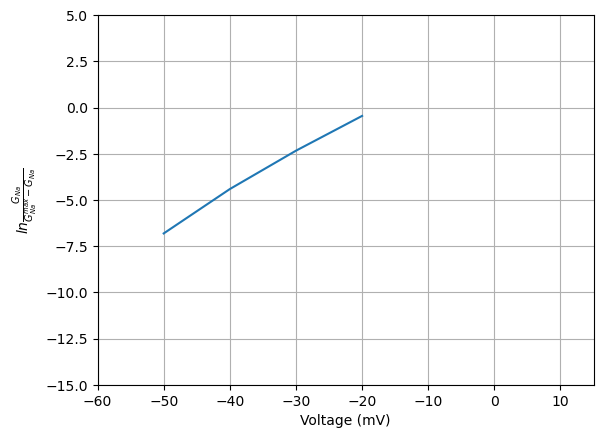

In [6]:
start_scope()
g18nav = 200 * nS
m3h_s_eq = m3h_s_model + Equations("v : volt (constant)")
m3h_s_model_neuron = NeuronGroup(1, model=m3h_s_eq, method="exponential_euler", namespace={"gNa18": g18nav})
m3h_s_model_statemon = StateMonitor(m3h_s_model_neuron, ["INa18", "m", "h"], record=True)

m3h_s_model_neuron.h = 1
store("m3h_s_model")

m3h_s_max_gs = max_conductances(experimental_voltages, m3h_s_model_neuron, m3h_s_model_statemon, "m3h_s_model")
plot_ln_G_vs_voltages(m3h_s_max_gs, experimental_voltages, g18nav)

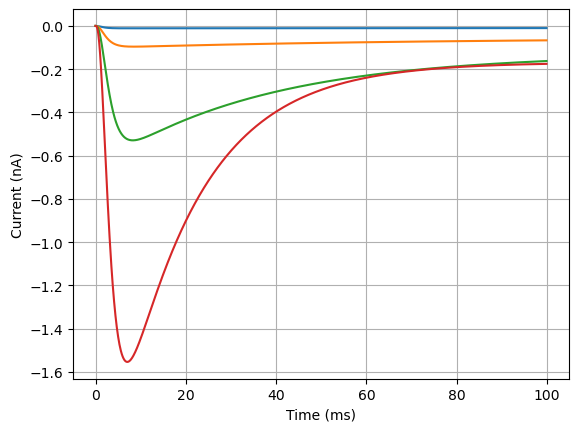

In [7]:
# Plot currents
plot_currents(experimental_voltages, m3h_s_model_neuron, m3h_s_model_statemon, "m3h_s_model")

### $m^3h_f$

WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -40. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -30. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -20. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


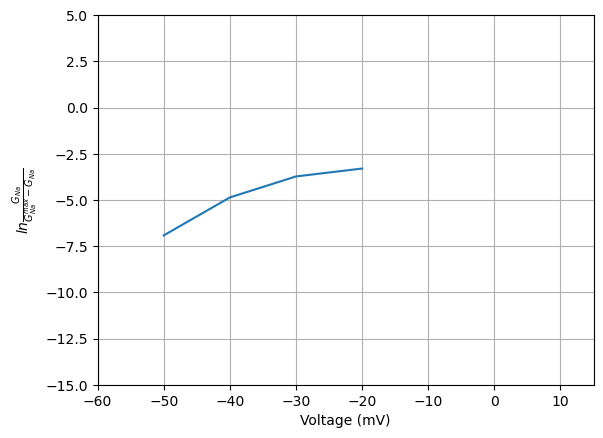

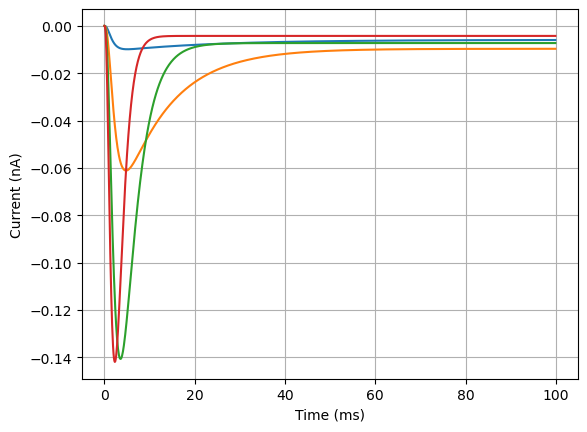

In [11]:
start_scope()
g18nav = 200*nS
m3h_f_eq = m3h_f_model + Equations("v : volt (constant)")
m3h_f_neuron = NeuronGroup(1, model=m3h_f_eq, method="exponential_euler", namespace={"gNa18": g18nav})
m3h_f_model_statemon = StateMonitor(m3h_f_neuron, ["INa18", "m", "h"], record=True)

m3h_f_neuron.h = 1
store("m3h_f_model")

m3h_f_max_gs = max_conductances(experimental_voltages, m3h_f_neuron, m3h_f_model_statemon, "m3h_f_model")
plot_ln_G_vs_voltages(m3h_f_max_gs, experimental_voltages, g18nav)
figure()
plot_currents(experimental_voltages, m3h_f_neuron, m3h_f_model_statemon, "m3h_f_model")

#### Сводка по всем моделям

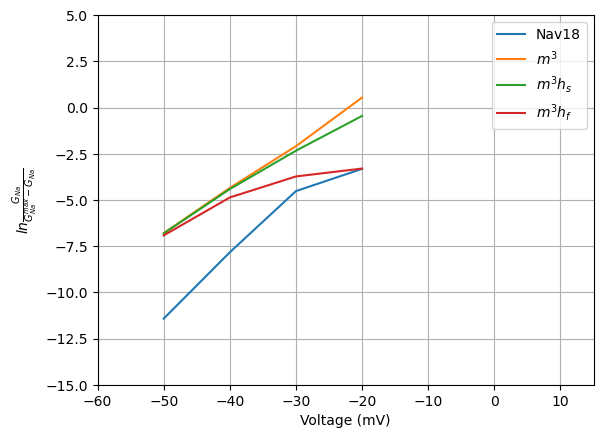

In [37]:
models_gs = [nav18_max_gs, m3_max_gs, m3h_s_max_gs, m3h_f_max_gs]
model_names = ["Nav18", "$m^3$", "$m^3h_s$", "$m^3h_f$"]

for gs in models_gs:
    plot_ln_G_vs_voltages(gs, experimental_voltages, g18nav)
legend(model_names)

In [38]:
for gs, name in zip(models_gs, model_names):
    print(f"{name} = {comp_Zeff(gs, experimental_voltages, g18nav)}")

Nav18 = 0.3589695552092818
$m^3$ = 0.24504719210958645
$m^3h_s$ = 0.24011880132400018
$m^3h_f$ = 0.20539741833948574


# Пробую повлиять на $Z_{eff}$

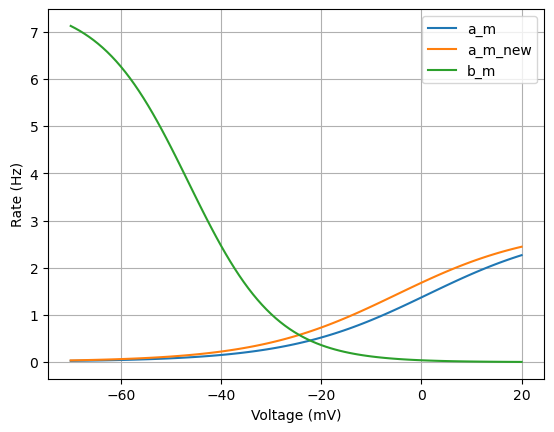

In [14]:
# plot equations (alpha and beta by voltage)
vv = linspace(-70, 20, 100)
a_m = 2.85 - 2.84 / (1 + exp((vv - 1.16) / 13.95))
a_m_new = 2.85 - 2.84 / (1 + exp((vv +5.0) / 13.95))
b_m = 7.62 / (1 + exp((vv + 46.5) / 8.83))
plot(vv, a_m, label="a_m")
plot(vv, a_m_new, label="a_m_new")
plot(vv, b_m, label="b_m")
xlabel("Voltage (mV)")
ylabel("Rate (Hz)")
legend()
grid()

In [20]:
# create neuron with new equations (slightly different)
start_scope()
g18nav = 200*nS
mod_gna18_eq = gNa18_eq_modified + Equations("v : volt (constant)")

mod_nav18_neuron = NeuronGroup(1, mod_gna18_eq,
                               namespace={"gNa18": g18nav}, method="exponential_euler",
                               name="Nav18")
mod_nav18_statemon = StateMonitor(mod_nav18_neuron, ["INa18"], True)

store("patch_clamp_init")

experimental_voltages = arange(-50, -10, 10) * mV
mod_nav18_max_gs = max_conductances(experimental_voltages, mod_nav18_neuron, mod_nav18_statemon, "patch_clamp_init")


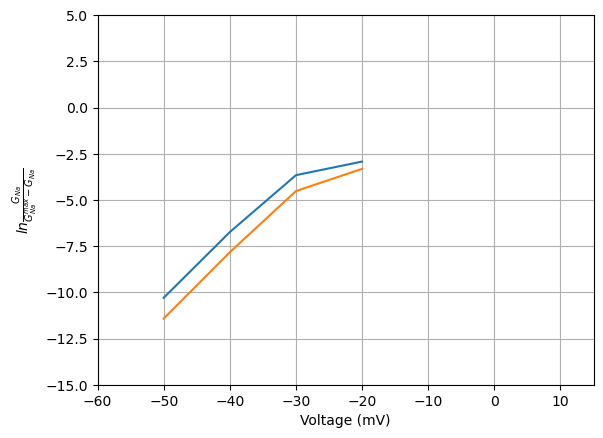

In [35]:
plot_ln_G_vs_voltages(mod_nav18_max_gs, experimental_voltages, g18nav)
plot_ln_G_vs_voltages(nav18_max_gs, experimental_voltages, g18nav)

In [30]:
print(comp_Zeff(mod_nav18_max_gs, experimental_voltages, g18nav))
print(comp_Zeff(nav18_max_gs, experimental_voltages, g18nav))

0.3556558893718752
0.3589695552092818
